In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-26 09:11:23--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  11.5MB/s    in 26s     

2022-05-26 09:11:50 (12.0 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='FocalLoss

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-26 09:11:51,447 - mmseg - INFO - Loaded 537 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-26 09:11:55,220 - mmseg - INFO - Loaded 113 images
2022-05-26 09:11:55,223 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-26 09:11:55,666 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 464s, ETA:     0s

2022-05-26 09:28:07,746 - mmseg - INFO - per class results:
2022-05-26 09:28:07,748 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.11 | 92.47 |
|  building  |  71.1 | 90.38 |
|  Boundary  | 38.73 | 49.07 |
+------------+-------+-------+
2022-05-26 09:28:07,750 - mmseg - INFO - Summary:
2022-05-26 09:28:07,753 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.89 | 65.65 | 77.31 |
+-------+-------+-------+
2022-05-26 09:28:07,755 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8589, mIoU: 0.6565, mAcc: 0.7731, IoU.background: 0.8711, IoU.building: 0.7110, IoU.Boundary: 0.3873, Acc.background: 0.9247, Acc.building: 0.9038, Acc.Boundary: 0.4907
2022-05-26 09:28:41,258 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:47:56, time: 4.979, data_time: 4.671, memory: 3323, decode.loss_ce: 0.4520, decode.loss_focal: 0.0428, decode.loss_lovasz: 0.3985, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-26 09:40:48,997 - mmseg - INFO - per class results:
2022-05-26 09:40:48,998 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  88.8 | 94.43 |
|  building  | 74.72 | 84.98 |
|  Boundary  | 48.03 | 64.51 |
+------------+-------+-------+
2022-05-26 09:40:48,999 - mmseg - INFO - Summary:
2022-05-26 09:40:49,002 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.95 | 70.51 | 81.31 |
+-------+-------+-------+
2022-05-26 09:40:49,004 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8795, mIoU: 0.7051, mAcc: 0.8131, IoU.background: 0.8880, IoU.building: 0.7472, IoU.Boundary: 0.4803, Acc.background: 0.9443, Acc.building: 0.8498, Acc.Boundary: 0.6451
2022-05-26 09:41:20,341 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:10:41, time: 4.610, data_time: 4.303, memory: 3323, decode.loss_ce: 0.3952, decode.loss_focal: 0.0388, decode.loss_lovasz: 0.3675, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-26 09:53:28,376 - mmseg - INFO - per class results:
2022-05-26 09:53:28,378 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  87.0 | 97.37 |
|  building  |  72.5 | 79.11 |
|  Boundary  | 43.07 | 54.02 |
+------------+-------+-------+
2022-05-26 09:53:28,379 - mmseg - INFO - Summary:
2022-05-26 09:53:28,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.87 | 67.52 | 76.83 |
+-------+-------+-------+
2022-05-26 09:53:28,384 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8687, mIoU: 0.6752, mAcc: 0.7683, IoU.background: 0.8700, IoU.building: 0.7250, IoU.Boundary: 0.4307, Acc.background: 0.9737, Acc.building: 0.7911, Acc.Boundary: 0.5402
2022-05-26 09:53:59,718 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:49:19, time: 4.626, data_time: 4.318, memory: 3323, decode.loss_ce: 0.3678, decode.loss_focal: 0.0365, decode.loss_lovasz: 0.3506, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-26 10:06:07,258 - mmseg - INFO - per class results:
2022-05-26 10:06:07,260 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.16 | 94.75 |
|  building  | 75.89 | 85.61 |
|  Boundary  | 49.71 | 65.84 |
+------------+-------+-------+
2022-05-26 10:06:07,261 - mmseg - INFO - Summary:
2022-05-26 10:06:07,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.48 | 71.59 | 82.06 |
+-------+-------+-------+
2022-05-26 10:06:07,267 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8848, mIoU: 0.7159, mAcc: 0.8206, IoU.background: 0.8916, IoU.building: 0.7589, IoU.Boundary: 0.4971, Acc.background: 0.9475, Acc.building: 0.8561, Acc.Boundary: 0.6584
2022-05-26 10:06:38,692 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:32:11, time: 4.612, data_time: 4.303, memory: 3323, decode.loss_ce: 0.3312, decode.loss_focal: 0.0324, decode.loss_lovasz: 0.3285, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-26 10:18:47,110 - mmseg - INFO - per class results:
2022-05-26 10:18:47,112 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.91 | 92.95 |
|  building  | 75.94 | 89.87 |
|  Boundary  | 50.24 | 65.79 |
+------------+-------+-------+
2022-05-26 10:18:47,113 - mmseg - INFO - Summary:
2022-05-26 10:18:47,115 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 88.4 | 71.7 | 82.87 |
+------+------+-------+
2022-05-26 10:18:47,117 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8840, mIoU: 0.7170, mAcc: 0.8287, IoU.background: 0.8891, IoU.building: 0.7594, IoU.Boundary: 0.5024, Acc.background: 0.9295, Acc.building: 0.8987, Acc.Boundary: 0.6579
2022-05-26 10:19:18,485 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:16:51, time: 4.610, data_time: 4.302, memory: 3323, decode.loss_ce: 0.3257, decode.loss_focal: 0.0314, decode.loss_lovasz: 0.3345, decode.acc_seg: 86.9810

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-26 10:31:24,777 - mmseg - INFO - per class results:
2022-05-26 10:31:24,779 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.64 |  93.9 |
|  building  | 77.33 | 88.05 |
|  Boundary  | 51.79 | 69.15 |
+------------+-------+-------+
2022-05-26 10:31:24,780 - mmseg - INFO - Summary:
2022-05-26 10:31:24,783 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.01 | 72.92 | 83.7 |
+-------+-------+------+
2022-05-26 10:31:24,786 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8901, mIoU: 0.7292, mAcc: 0.8370, IoU.background: 0.8964, IoU.building: 0.7733, IoU.Boundary: 0.5179, Acc.background: 0.9390, Acc.building: 0.8805, Acc.Boundary: 0.6915
2022-05-26 10:31:56,126 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:02:18, time: 4.610, data_time: 4.302, memory: 3323, decode.loss_ce: 0.3074, decode.loss_focal: 0.0304, decode.loss_lovasz: 0.3168, decode.acc_seg: 87

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-26 10:44:06,234 - mmseg - INFO - per class results:
2022-05-26 10:44:06,236 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.68 | 94.74 |
|  building  | 77.36 | 87.94 |
|  Boundary  | 51.21 | 66.23 |
+------------+-------+-------+
2022-05-26 10:44:06,237 - mmseg - INFO - Summary:
2022-05-26 10:44:06,241 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.1 | 72.75 | 82.97 |
+------+-------+-------+
2022-05-26 10:44:06,243 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8910, mIoU: 0.7275, mAcc: 0.8297, IoU.background: 0.8968, IoU.building: 0.7736, IoU.Boundary: 0.5121, Acc.background: 0.9474, Acc.building: 0.8794, Acc.Boundary: 0.6623
2022-05-26 10:44:37,791 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:48:25, time: 4.628, data_time: 4.319, memory: 3323, decode.loss_ce: 0.3035, decode.loss_focal: 0.0307, decode.loss_lovasz: 0.3084, decode.acc_seg: 88

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-26 10:56:45,196 - mmseg - INFO - per class results:
2022-05-26 10:56:45,198 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.96 | 94.78 |
|  building  | 77.85 | 87.29 |
|  Boundary  | 52.26 |  68.8 |
+------------+-------+-------+
2022-05-26 10:56:45,199 - mmseg - INFO - Summary:
2022-05-26 10:56:45,201 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.32 | 73.36 | 83.62 |
+-------+-------+-------+
2022-05-26 10:56:45,203 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8932, mIoU: 0.7336, mAcc: 0.8362, IoU.background: 0.8996, IoU.building: 0.7785, IoU.Boundary: 0.5226, Acc.background: 0.9478, Acc.building: 0.8729, Acc.Boundary: 0.6880
2022-05-26 10:57:18,582 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:34:49, time: 4.649, data_time: 4.341, memory: 3323, decode.loss_ce: 0.2769, decode.loss_focal: 0.0274, decode.loss_lovasz: 0.2938, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 11:09:28,094 - mmseg - INFO - per class results:
2022-05-26 11:09:28,096 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.13 | 94.76 |
|  building  | 77.99 | 88.68 |
|  Boundary  | 52.12 | 67.25 |
+------------+-------+-------+
2022-05-26 11:09:28,098 - mmseg - INFO - Summary:
2022-05-26 11:09:28,102 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.44 | 73.41 | 83.56 |
+-------+-------+-------+
2022-05-26 11:09:28,104 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8944, mIoU: 0.7341, mAcc: 0.8356, IoU.background: 0.9013, IoU.building: 0.7799, IoU.Boundary: 0.5212, Acc.background: 0.9476, Acc.building: 0.8868, Acc.Boundary: 0.6725
2022-05-26 11:09:59,273 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:21:24, time: 4.635, data_time: 4.329, memory: 3323, decode.loss_ce: 0.2718, decode.loss_focal: 0.0265, decode.loss_lovasz: 0.2962, decode.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 11:22:09,616 - mmseg - INFO - per class results:
2022-05-26 11:22:09,618 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.21 | 96.07 |
|  building  | 77.01 | 84.04 |
|  Boundary  | 52.21 | 68.78 |
+------------+-------+-------+
2022-05-26 11:22:09,619 - mmseg - INFO - Summary:
2022-05-26 11:22:09,622 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.33 | 73.14 | 82.96 |
+-------+-------+-------+
2022-05-26 11:22:09,625 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8933, mIoU: 0.7314, mAcc: 0.8296, IoU.background: 0.9021, IoU.building: 0.7701, IoU.Boundary: 0.5221, Acc.background: 0.9607, Acc.building: 0.8404, Acc.Boundary: 0.6878
2022-05-26 11:22:40,413 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:08:09, time: 4.632, data_time: 4.329, memory: 3323, decode.loss_ce: 0.2554, decode.loss_focal: 0.0254, decode.loss_lovasz: 0.2793, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 11:34:46,764 - mmseg - INFO - per class results:
2022-05-26 11:34:46,765 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.29 | 94.63 |
|  building  | 78.44 | 89.49 |
|  Boundary  | 52.21 | 67.34 |
+------------+-------+-------+
2022-05-26 11:34:46,767 - mmseg - INFO - Summary:
2022-05-26 11:34:46,771 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.56 | 73.65 | 83.82 |
+-------+-------+-------+
2022-05-26 11:34:46,773 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8956, mIoU: 0.7365, mAcc: 0.8382, IoU.background: 0.9029, IoU.building: 0.7844, IoU.Boundary: 0.5221, Acc.background: 0.9463, Acc.building: 0.8949, Acc.Boundary: 0.6734
2022-05-26 11:35:17,818 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:54:57, time: 4.636, data_time: 4.331, memory: 3323, decode.loss_ce: 0.2745, decode.loss_focal: 0.0271, decode.loss_lovasz: 0.2938, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 11:47:26,868 - mmseg - INFO - per class results:
2022-05-26 11:47:26,870 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.33 |  94.2 |
|  building  | 78.85 | 90.18 |
|  Boundary  | 52.72 | 68.63 |
+------------+-------+-------+
2022-05-26 11:47:26,872 - mmseg - INFO - Summary:
2022-05-26 11:47:26,875 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.65 | 73.97 | 84.34 |
+-------+-------+-------+
2022-05-26 11:47:26,877 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8965, mIoU: 0.7397, mAcc: 0.8434, IoU.background: 0.9033, IoU.building: 0.7885, IoU.Boundary: 0.5272, Acc.background: 0.9420, Acc.building: 0.9018, Acc.Boundary: 0.6863
2022-05-26 11:47:58,311 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:41:52, time: 4.636, data_time: 4.328, memory: 3323, decode.loss_ce: 0.2894, decode.loss_focal: 0.0287, decode.loss_lovasz: 0.3040, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 12:00:06,345 - mmseg - INFO - per class results:
2022-05-26 12:00:06,347 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.34 |  94.7 |
|  building  | 78.44 | 88.56 |
|  Boundary  | 53.15 | 69.27 |
+------------+-------+-------+
2022-05-26 12:00:06,350 - mmseg - INFO - Summary:
2022-05-26 12:00:06,351 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.65 | 73.98 | 84.18 |
+-------+-------+-------+
2022-05-26 12:00:06,353 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8965, mIoU: 0.7398, mAcc: 0.8418, IoU.background: 0.9034, IoU.building: 0.7844, IoU.Boundary: 0.5315, Acc.background: 0.9470, Acc.building: 0.8856, Acc.Boundary: 0.6927
2022-05-26 12:00:37,448 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:28:51, time: 4.634, data_time: 4.328, memory: 3323, decode.loss_ce: 0.2951, decode.loss_focal: 0.0295, decode.loss_lovasz: 0.3047, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 12:12:44,560 - mmseg - INFO - per class results:
2022-05-26 12:12:44,562 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.49 | 94.06 |
|  building  | 79.22 | 90.31 |
|  Boundary  | 53.29 | 70.01 |
+------------+-------+-------+
2022-05-26 12:12:44,563 - mmseg - INFO - Summary:
2022-05-26 12:12:44,566 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.78 | 74.33 | 84.79 |
+-------+-------+-------+
2022-05-26 12:12:44,568 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8978, mIoU: 0.7433, mAcc: 0.8479, IoU.background: 0.9049, IoU.building: 0.7922, IoU.Boundary: 0.5329, Acc.background: 0.9406, Acc.building: 0.9031, Acc.Boundary: 0.7001
2022-05-26 12:13:15,466 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:15:52, time: 4.627, data_time: 4.324, memory: 3323, decode.loss_ce: 0.2567, decode.loss_focal: 0.0258, decode.loss_lovasz: 0.2790, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 12:25:21,031 - mmseg - INFO - per class results:
2022-05-26 12:25:21,034 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.7 | 95.08 |
|  building  | 79.06 | 89.51 |
|  Boundary  | 52.72 | 67.56 |
+------------+-------+-------+
2022-05-26 12:25:21,036 - mmseg - INFO - Summary:
2022-05-26 12:25:21,039 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.88 | 74.16 | 84.05 |
+-------+-------+-------+
2022-05-26 12:25:21,042 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8988, mIoU: 0.7416, mAcc: 0.8405, IoU.background: 0.9070, IoU.building: 0.7906, IoU.Boundary: 0.5272, Acc.background: 0.9508, Acc.building: 0.8951, Acc.Boundary: 0.6756
2022-05-26 12:25:54,035 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:02:56, time: 4.657, data_time: 4.353, memory: 3323, decode.loss_ce: 0.2351, decode.loss_focal: 0.0241, decode.loss_lovasz: 0.2708, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-26 12:37:53,620 - mmseg - INFO - per class results:
2022-05-26 12:37:53,623 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.56 | 94.62 |
|  building  | 79.05 | 89.22 |
|  Boundary  | 53.24 |  69.6 |
+------------+-------+-------+
2022-05-26 12:37:53,624 - mmseg - INFO - Summary:
2022-05-26 12:37:53,626 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.81 | 74.28 | 84.48 |
+-------+-------+-------+
2022-05-26 12:37:53,628 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8981, mIoU: 0.7428, mAcc: 0.8448, IoU.background: 0.9056, IoU.building: 0.7905, IoU.Boundary: 0.5324, Acc.background: 0.9462, Acc.building: 0.8922, Acc.Boundary: 0.6960
2022-05-26 12:38:24,605 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:50:01, time: 4.633, data_time: 4.329, memory: 3323, decode.loss_ce: 0.2470, decode.loss_focal: 0.0247, decode.loss_lovasz: 0.2740, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 12:50:29,370 - mmseg - INFO - per class results:
2022-05-26 12:50:29,372 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.7 | 95.19 |
|  building  | 79.09 | 88.62 |
|  Boundary  | 53.11 | 68.77 |
+------------+-------+-------+
2022-05-26 12:50:29,374 - mmseg - INFO - Summary:
2022-05-26 12:50:29,376 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 89.9 | 74.3 | 84.19 |
+------+------+-------+
2022-05-26 12:50:29,378 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8990, mIoU: 0.7430, mAcc: 0.8419, IoU.background: 0.9070, IoU.building: 0.7909, IoU.Boundary: 0.5311, Acc.background: 0.9519, Acc.building: 0.8862, Acc.Boundary: 0.6877
2022-05-26 12:51:00,437 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:37:09, time: 4.644, data_time: 4.339, memory: 3323, decode.loss_ce: 0.2466, decode.loss_focal: 0.0249, decode.loss_lovasz: 0.2759, decode.acc_seg: 89.994

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 13:03:04,487 - mmseg - INFO - per class results:
2022-05-26 13:03:04,488 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.55 | 94.32 |
|  building  | 79.07 | 89.91 |
|  Boundary  | 53.31 |  69.7 |
+------------+-------+-------+
2022-05-26 13:03:04,490 - mmseg - INFO - Summary:
2022-05-26 13:03:04,491 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.8 | 74.31 | 84.64 |
+------+-------+-------+
2022-05-26 13:03:04,493 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8980, mIoU: 0.7431, mAcc: 0.8464, IoU.background: 0.9055, IoU.building: 0.7907, IoU.Boundary: 0.5331, Acc.background: 0.9432, Acc.building: 0.8991, Acc.Boundary: 0.6970
2022-05-26 13:03:35,503 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:24:19, time: 4.644, data_time: 4.339, memory: 3323, decode.loss_ce: 0.2296, decode.loss_focal: 0.0228, decode.loss_lovasz: 0.2700, decode.acc_seg: 9

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 13:15:37,995 - mmseg - INFO - per class results:
2022-05-26 13:15:37,997 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.71 | 95.02 |
|  building  | 79.31 | 89.19 |
|  Boundary  | 53.23 | 68.83 |
+------------+-------+-------+
2022-05-26 13:15:37,999 - mmseg - INFO - Summary:
2022-05-26 13:15:38,003 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.94 | 74.42 | 84.35 |
+-------+-------+-------+
2022-05-26 13:15:38,005 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8994, mIoU: 0.7442, mAcc: 0.8435, IoU.background: 0.9071, IoU.building: 0.7931, IoU.Boundary: 0.5323, Acc.background: 0.9502, Acc.building: 0.8919, Acc.Boundary: 0.6883
2022-05-26 13:16:08,950 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:30, time: 4.642, data_time: 4.338, memory: 3323, decode.loss_ce: 0.2364, decode.loss_focal: 0.0235, decode.loss_lovasz: 0.2669, decode.acc_s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-26 13:28:11,551 - mmseg - INFO - per class results:
2022-05-26 13:28:11,553 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.72 | 94.85 |
|  building  | 79.27 | 88.73 |
|  Boundary  | 53.65 | 70.37 |
+------------+-------+-------+
2022-05-26 13:28:11,554 - mmseg - INFO - Summary:
2022-05-26 13:28:11,556 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.94 | 74.55 | 84.65 |
+-------+-------+-------+
2022-05-26 13:28:11,560 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8994, mIoU: 0.7455, mAcc: 0.8465, IoU.background: 0.9072, IoU.building: 0.7927, IoU.Boundary: 0.5365, Acc.background: 0.9485, Acc.building: 0.8873, Acc.Boundary: 0.7037


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


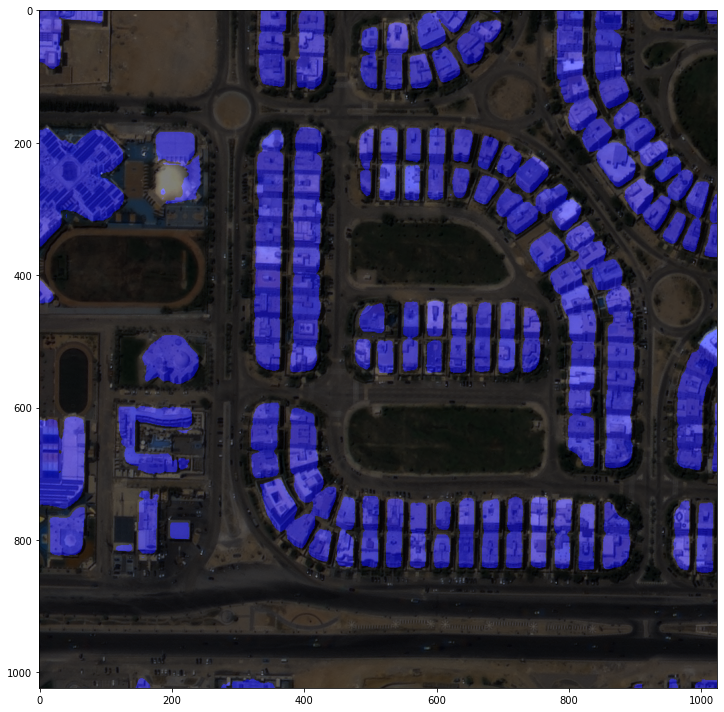

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


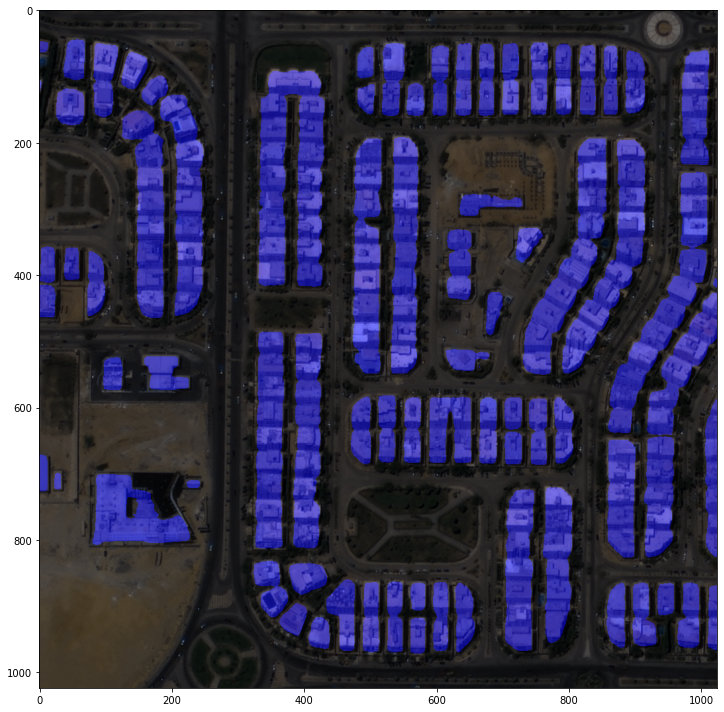

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


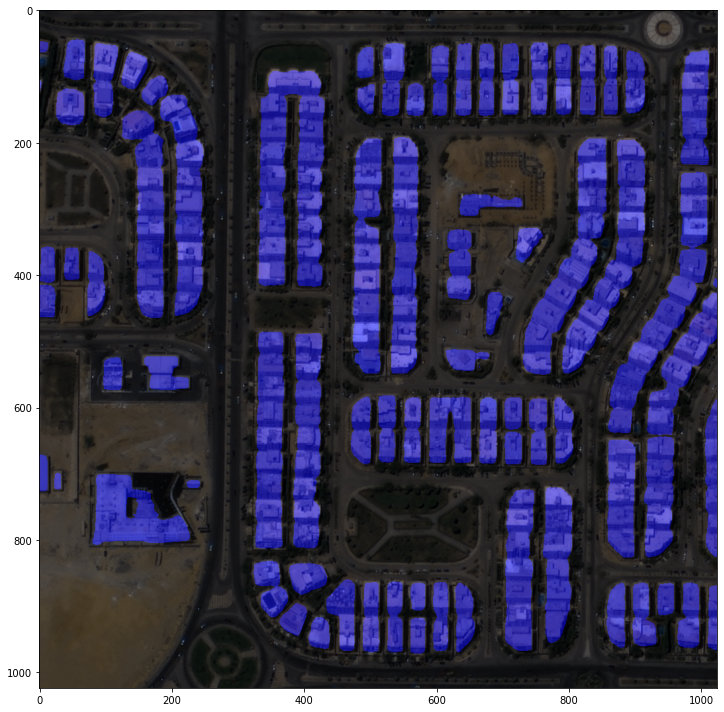

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


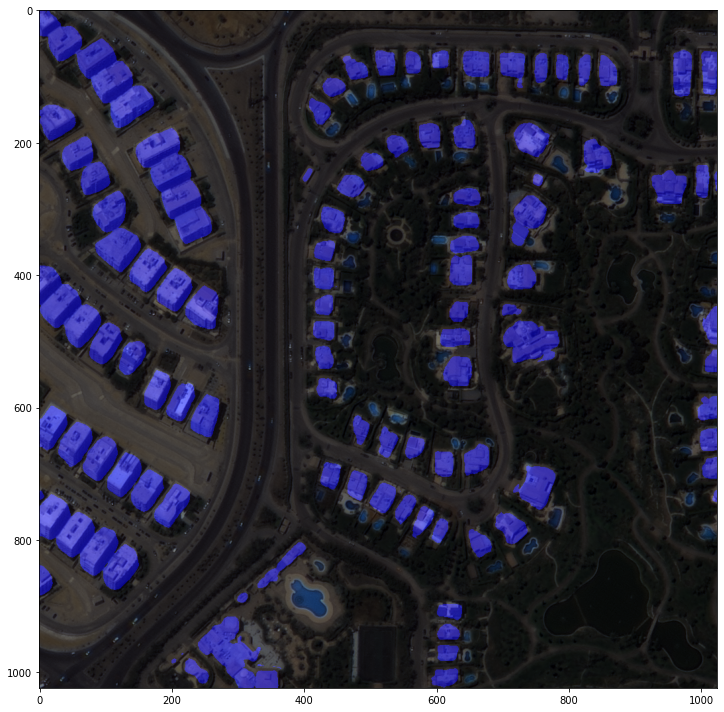

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


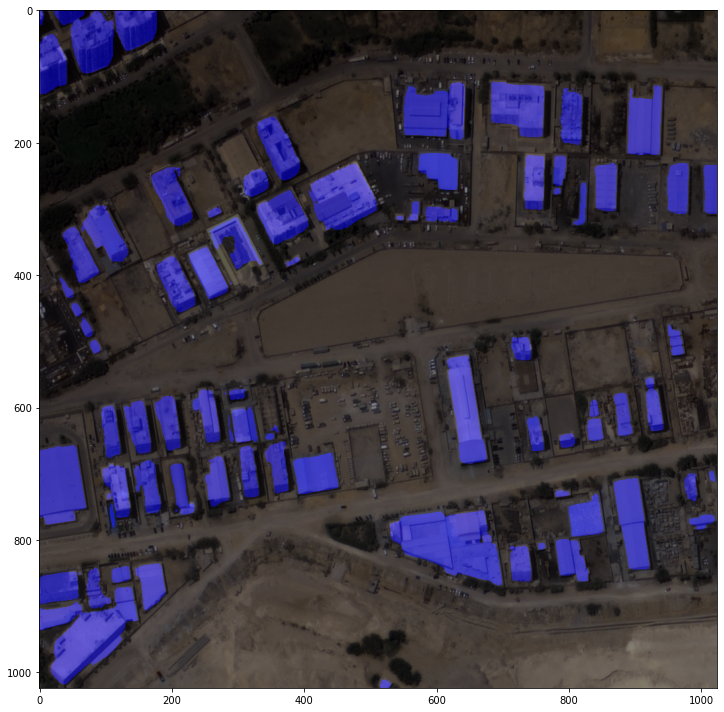

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


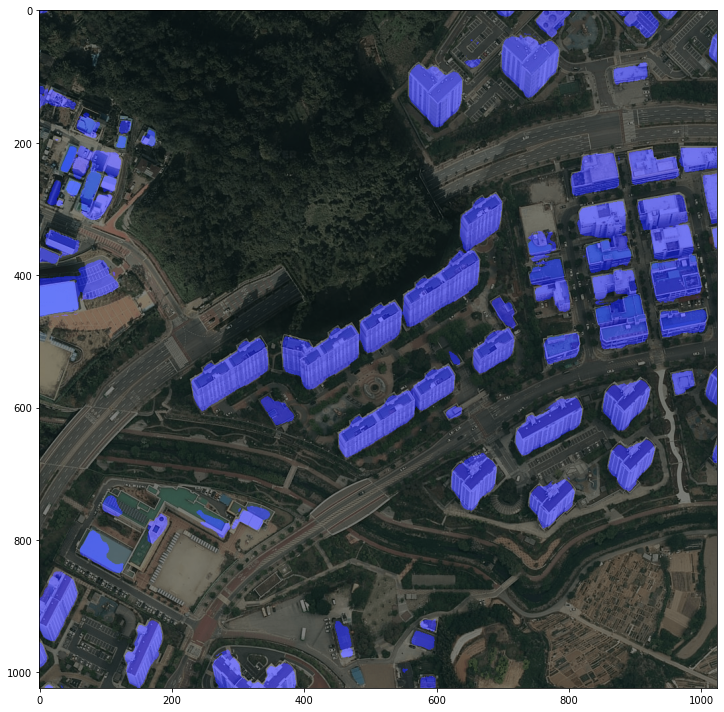

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


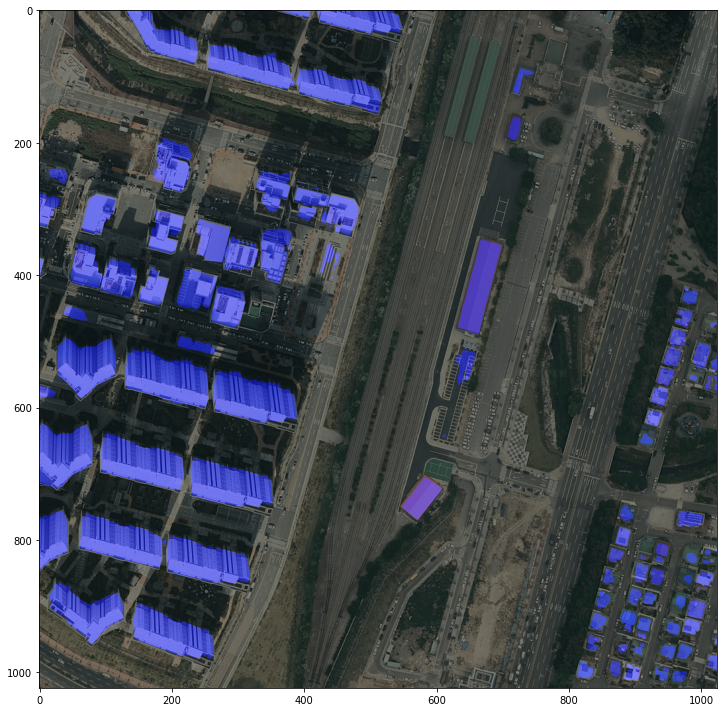

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


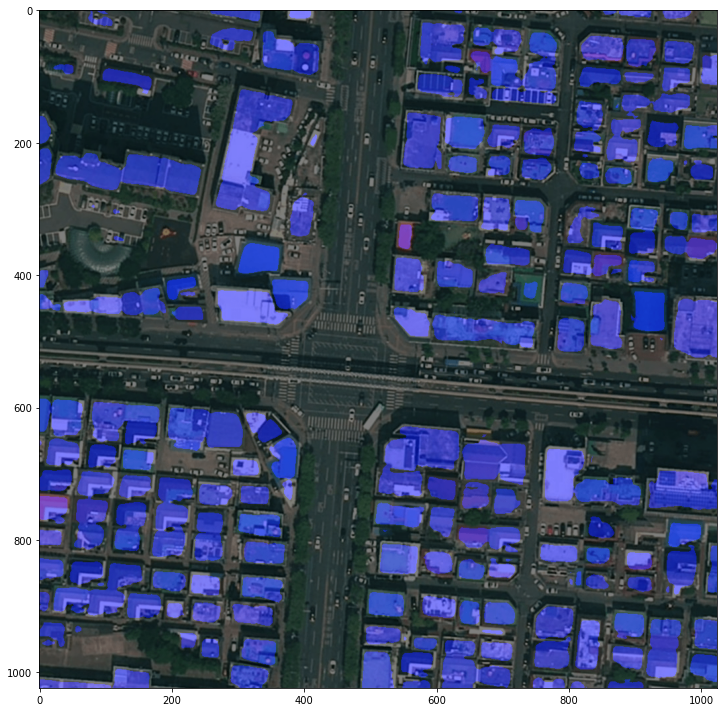

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)